In [1]:
import sys
import numpy as np 
import matplotlib.pyplot as plt 

sys.path.append("pwd")

# import custom shit 
sys.path.append('/Users/simon/Dropbox/Python/Optics/CoatingDevelopment/coatingstack/')
import YAM_CoatingBrownian 
import EFI_tmm 
sys.path.append('/Users/simon/Dropbox/Python/Optics/CoatingDevelopment/coatingstack/TiGe_Optimisation')
import Coatings_development as coatDef

import os 
import pandas as pd 

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd


def find_brownian_noise_for_frequency(dataset, frequency=100):
        # Find indices where 'Frequency' equals the specified frequency
    indices = [i for i, freq in enumerate(dataset['Frequency']) if freq == frequency]
    # Return the 'BrownianNoise' values for these indices
    return [dataset['BrownianNoise'][i] for i in indices]


In [3]:
materialParams = {
    1: {
        'name' : 'SiO2',
        'n'    : 1.45,
        'a'    : 0,
        'alpha': 0.51e-6, # Fejer et al
        'beta' : 8e-6,    # dn/dT,        (ref. 14)
        'kappa': 1.38,
        'C'    : 1.64e6,  # Crooks et al, Fejer et al
        'Y'    : 70e9,    # 2020 LMA
        'prat' : 0.17,
        # 'phiM' : 1.25e-5, # silica mechanical loss
        'phiM' : 2.3e-5,    #Grand Coater 

        # 'k'    : 0,       #        right now assuming absorption of silica at 1064 is negligable.
        'k'    : 3E-8,       #        right now assuming absorption of silica at 1064 is negligable.
        
    },
    2: {
        'name' : 'Ti:Ta2O5',
        'n'    : 2.05,       # 2020 LMA
        'a'    : 2,
        'alpha': 3.6e-6,     # 3.6e-6 Fejer et al,             5e-6 from Braginsky
        'beta' : 14e-6,      # dn/dT,                          value Gretarrson (G070161)
        'kappa': 33,         # Fejer et al
        'C'    : 2.1e6,      # Crooks et al,                   Fejer et al
        'Y'    : 120e9,      # Ta2O5-TiO2 from 2020 LMA https: //iopscience.iop.org/article/10.1088/1361-6382/ab77e9
        'prat' : 0.23,
        'phiM' : 2.3E-4,     # tantala mechanical loss
       # 'phiM' : 3.6E-4,     # tantala mechanical loss
        # 'k'    : 1E-7,       # measured by S.Tait for RLVIP tantala  at 1064nm
        'k'    : 5E-8,       #Grand Coater 
        
    },

    3: {
        'name' : 'TiGermaia', 
        'n'    : 1.89,          # Grand Coater Refractive Index 
        'a'    : 1,
        'alpha': 12.82e-7,      # Measured by A.Grettarson  therm. expansion coef of the high index layer
        # 'alpha': 0*3.6e-6,      # Measured by A.Grettarson  therm. expansion coef of the high index layer
        # 'alpha': 0*3.6e-6,      # Measured by A.Grettarson  therm. expansion coef of the high index layer
        # 'beta' : 2.03e-5,       # Measured by A.Grettarson  therm. expansion coef of the high index layer
         'beta' : 2.4e-5,       # Measured by A.Grettarson  therm. expansion coef of the high index layer
        # 'beta' : -9.6e-5,       # Measured by A.Grettarson  therm. expansion coef of the high index layer
        'kappa': 33,
        'C'    : 2.51e6,
        'Y'    : 92E9,          # Christophe - LMA 
        'prat' : 0.25,          # Christophe - LMA 
        'phiM' : 1E-4,        # Grand Coater 
        # 'phiM' : 5E-5,        # Measured on LMA single Layer TiGE
        'k'    :  2E-7  ,       # Grand. Coater 
        # 'k'    :  1E-7  ,   # https://dcc.ligo.org/DocDB/0188/G2301290/001/Ti-GeO2%20RD%20Working%20Group-%20LMA%20status%2007052023.pdf
    }, 
    
    4: {
        'name' : 'TiSiO2',
        'n'    : 1.90,
        'a'    : 2,
        'alpha': 1e-6,
        'beta' : 14e-6,
        'kappa': 33,
        'C'    : 2.1e6,
        'Y'    : 103.8E9,
        'prat' : 0.241,
        'phiM' : 2.49E-4,
        'k'    : 1E-4,     #measured by S.Tait for RLVIP tantala  at 1064nm
    },

    999: {
        'name' : 'air',
        'n'    : 1,
        'a'    : np.NaN,
        'alpha': np.NaN,
        'beta' : np.NaN,
        'kappa': np.NaN,
        'C'    : np.NaN,
        'Y'    : np.NaN,
        'prat' : np.NaN,
        'phiM' : np.NaN,
    }
}

In [4]:
ultimate_dict = {}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


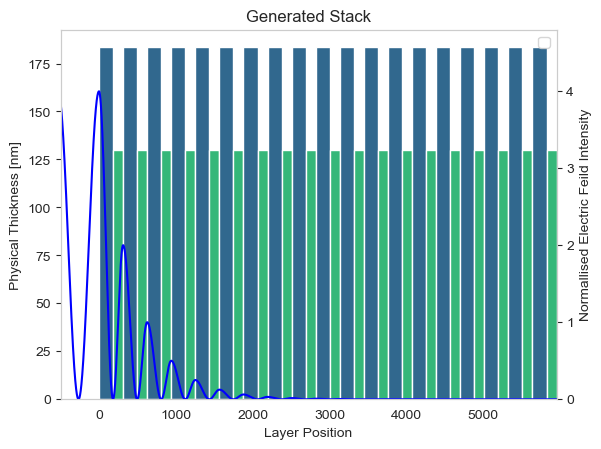


Coating Properties:

Laser Wavelength:               1064.00 nm
Number of Materials:            2
Total Physical Thickness:       5.95e-06 m
absorption:                     0.35 ppm
CTN_at_100Hz:                   5.434387029871012e-21
Reflectivity_1064:              0.99999
stack_name:                     aLIGO BaseLine

--------- Material 1 -------------

No. Layers:			19
Total Physical Thickness:	3.49e-06 m
Refractive Index:		1.45

--------- Material 2 -------------

No. Layers:			19
Total Physical Thickness:	2.47e-06 m
Refractive Index:		2.05


In [ ]:
### Setting Up IFO paramaters 

wBeam = 0.062;               # 6cm beam for aLIGO 
lambda_ = 1064e-9;           # laser wavelength

Temp = 293;                  # temperature - Room temperature 
f = np.logspace(0, 3, 100);  # frequencies for plotting


## Setting up coating design 

## set up aLIGO Coating Stack to benchmark functions 
num21 = 19  # number of 1-2 doublets (includes cap)
num34 = 0   # number of 3-4 doublets

# Using list comprehension to replicate the behavior of MATLAB's repmat
#  values here correspond to the keys in  the materialParams dict 

materialLayer = [1, 2] * num21 + [1, 2] * num34
materialLayer = np.array(materialLayer)

# Optical Thickness of each layer  - currently assuming all layers are 1/4 wave at lambda_
dOpt =np.ones(len(materialLayer))*0.25 
dOpt =np.array(dOpt)


# Inputs/Outputs dictionary
aLIGO_params = {} 


# Inputs/Outputs dictionary
diChroic = {} 

## INPUTS 


diChroic['StackName']      = 'aLIGO BaseLine'                   # Label for run 
diChroic["dOpt"]           = dOpt                               # optical thickness array 
diChroic["materialLayer"]  = materialLayer                      # material array containing keys which index materialParams
diChroic["materialParams"] = materialParams                     # dictionary of material properties 
diChroic["materialSub"]    = 1                                  # substrate type - Silica 
diChroic["lambda_"]        = lambda_                            # IFO wavelength 
diChroic["f"]              = f                                  # Frequency range to evaluate CTN 
diChroic["wBeam"]          = wBeam                              # laser beam size on ETM 
diChroic["Temp"]           = Temp                               # detector temperature 
diChroic["plots "]         = False                              # boolean for activating plots 
diChroic["t_air"]          = 500                                # thickness of air in EFI calculations for optical absorption : Default is 500nm
diChroic["polarisation"]   = 'p'                                # light polarisation for EFI calculations 
diChroic["lambda_list"]    = np.linspace(0, lambda_*2, 2000)  # list of wavelengths to evaluate transmission spectra ( MUST BE BETWEEN 0 AND X ...
                                                                    # calculation fails if inital value is greater than zero ..... unsure why ) 



# Calcualte CTN of coating 
Noises, rCoat, dcdp, rbar, r = YAM_CoatingBrownian.getCoatingThermalNoise(diChroic["dOpt"],\
                                                                                diChroic["materialLayer"],
                                                                                diChroic["materialParams"],
                                                                                diChroic["materialSub"],
                                                                                diChroic["lambda_"],
                                                                                diChroic["f"],
                                                                                diChroic["wBeam"],
                                                                                diChroic["Temp"],
                                                                                plots = False)
# Calcualte optical absorption of coating 
EFI, layer_idx , ds,E, poyn, absor= EFI_tmm.CalculateEFI_tmm(diChroic["dOpt"],\
                                                             diChroic["materialLayer"],
                                                             diChroic["materialParams"],
                                                             diChroic["lambda_"],
                                                             diChroic["t_air"],
                                                             diChroic["polarisation"], 
                                                             plots =True )



# Calcualte Transmission Spectra 
_, transmission,transmission_lambda_0  =EFI_tmm.CalculateTransmission_tmm(diChroic["dOpt"] ,\
                                                            diChroic["materialLayer"],
                                                            diChroic["materialParams"],
                                                            diChroic["lambda_list"],
                                                            diChroic["lambda_"] ,
                                                            polarisation='p',
                                                            plots=True)
    
    


# Find coating thermal noise at frequency =100Hz 
BN_at_F = find_brownian_noise_for_frequency(Noises, frequency=100)

diChroic['BrownianNoise_at_Frequency'] =  BN_at_F
diChroic['Targeted_Frequency'] =  100


## OUTPUTS  
diChroic["Noises"] = Noises
diChroic["rCoat"]  = rCoat
diChroic["dcdp"]   = dcdp
diChroic["rbar"]   = rbar
diChroic["r"]      = r

diChroic["EFI"]            = EFI
diChroic["layer_idx "]     = layer_idx
diChroic["ds"]             = ds
diChroic["E"]              = E
diChroic["poyn"]           = poyn
diChroic["absor"]          = np.round(absor,decimals=2)

diChroic["transmission_spec"]     = transmission 
diChroic["transmission_lambda_0"] = transmission_lambda_0
diChroic['reflectivity_lambda_0'] = f"{1 - diChroic['transmission_lambda_0'] - diChroic['absor'] * 1e-6:.5f}"
 
nLayer = np.zeros(len(diChroic["materialLayer"]))
aLayer = np.zeros(len(diChroic["materialLayer"]))

for n, mat in enumerate(diChroic["materialLayer"]):
    nLayer[n] = materialParams[mat]['n']

diChroic["nLayer"] = nLayer 


base_path ="/Users/simon/Dropbox/Python/Optics/CoatingDevelopment/coatingstack/TiGe_Optimisation"
n_layers, material_kind,d_physical_layers = coatDef.thin_film_stack(diChroic["nLayer"], 
                                                                    diChroic["materialLayer"], 
                                                                    diChroic["lambda_"], 
                                                                    base_path=base_path, 
                                                                    plots=False, 
                                                                    absorption=str(diChroic["absor"]) + ' ppm',
                                                                    CTN_at_100Hz=diChroic['BrownianNoise_at_Frequency'][0],
                                                                    Reflectivity_1064 =diChroic['reflectivity_lambda_0'],
                                                                    stack_name=diChroic['StackName'] )

diChroic["n_layers"] = n_layers 
diChroic["material_kind"] = material_kind 
diChroic["d_physical_layers"] = d_physical_layers 

#keep things tidy    
del(Noises,BN_at_F,rCoat,dcdp,rbar,r,EFI,layer_idx,ds,E,poyn,absor,nLayer,n_layers, material_kind,d_physical_layers,transmission_lambda_0,transmission)

ultimate_dict[diChroic['StackName']] = diChroic


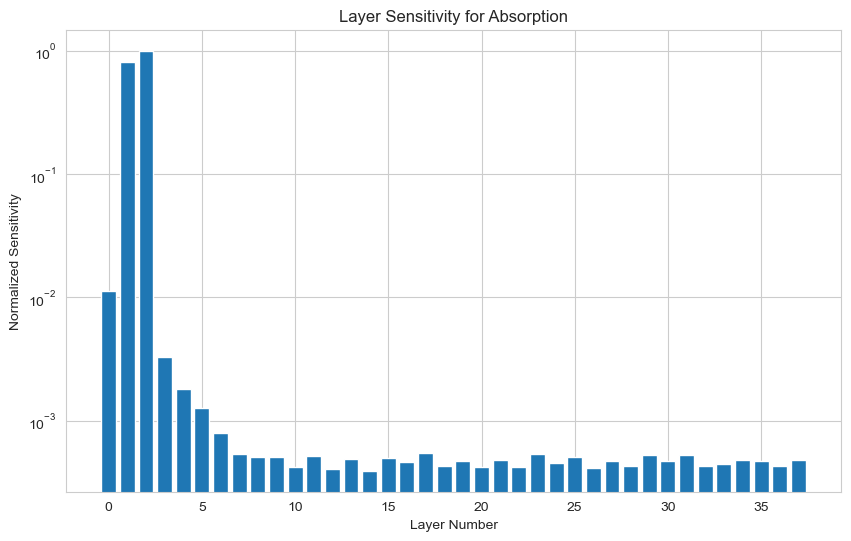

In [26]:
import matplotlib.pyplot as plt

# Plotting Absorption Sensitivity
plt.figure(figsize=(10, 6))
plt.bar(sensitivity_df['Layer'], sensitivity_df['Reflectivity_Sensitivity'])
plt.xlabel('Layer Number')
plt.ylabel('Normalized Sensitivity')
plt.title('Layer Sensitivity for Absorption')
plt.yscale('log')
plt.show()

# Similarly for CTN and Reflectivity

In [70]:
def parseTFCalc(file_path):
    Environment = {}
    layer_data = []  # List to store layer dictionaries
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split('*')
        if parts[0] == 'ENVIRON':
            # Extract environment settings
            Environment['Wavelength_range'] = [float(parts[1]), float(parts[2])]
            Environment['Target_lambda'] = float(parts[4])
            Environment['Medium'] = parts[6]
            Environment['Substrate'] = parts[7]
        elif parts[0] == 'LAYER':
            # Extract layer information
            layer_info = {
                'Layer': int(parts[1]),
                'Material': parts[2],
                'dOpt': float(parts[3]),
                'PhysicalThickness': float(parts[4]),
  
                # Add more parameters as needed
            }
            layer_data.append(layer_info)
    
    # Create a DataFrame from the layer data
    layer_df = pd.DataFrame(layer_data)
    layer_df.set_index('Layer', inplace=True)
    
    return Environment, layer_df

# Example usage:
file_path = '/Users/simon/Desktop/Tfcalc35/EXAMPLES/HR/aLIGO_45deg.tfd'

# Call the function with the file path
Environment, layer_df = parseTFCalc(file_path)

# Output the results
print("Environment Settings:")
for key, value in Environment.items():
    print(f"{key}: {value}")

# Create a new dictionary to hold the mapping from layer indices to material keys
materialLayer = {}
refractive_indicies = {} 
# Loop over each layer in the layer DataFrame
for i in layer_df.index:
    layer_material = layer_df.loc[i, 'Material'].lower()
    # Flag to check if a match is found
    match_found = False
    # Loop over keys in materialParams
    for key in materialParams:
        material_name = materialParams[key]['name'].lower()
        refractive_index = materialParams[key]['n']
        if layer_material in material_name:
            materialLayer[i] = key
            refractive_indicies[i] = refractive_index
            match_found = True
            break  # Exit the loop once a match is found
    if not match_found:
        # Handle the case where no matching material is found
        print(f"No matching material found for layer {i}: {layer_material}")
        materialLayer[i] = None  # Or assign a default value
        refractive_indicies= None 

# Now 'materialLayer' is a dictionary mapping layer indices to material keys in 'materialParams'

# Let's display the mapping
for layer_index in materialLayer:
    key = materialLayer[layer_index]

    if key is None:
         print(f"Layer {layer_index}: Material '{layer_df.loc[layer_index, 'Material']}' has no match in materialParams")

layer_df['materialLayer'] = materialLayer
layer_df['n'] = refractive_indicies

layer_df_reversed = layer_df.iloc[::-1]

Environment Settings:
Wavelength_range: [380.0, 1500.0]
Target_lambda: 1064.0
Medium: AIR
Substrate: GLASS


In [60]:

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from SALib.sample import morris
from SALib.analyze import morris as morris_analyze
import pandas as pd
import numpy as np

# Prepare lists to store outputs
Y_absorption = []
Y_CTN = []
Y_reflectivity = []


# Number of layers
num_layers = len(layer_df_reversed['dOpt'])

problem = {
    'num_vars': num_layers,
    'names': [f'dOpt_{i}' for i in range(num_layers)],
    'bounds': [
        [
            layer_df_reversed['dOpt'].iloc[i] * 0.99,
            layer_df_reversed['dOpt'].iloc[i] * 1.01
        ]  # ±1% variation
        for i in range(num_layers)
    ]
}

# Number of trajectories (adjust N as needed)
N = 50  # Lower N for less computational load, increase for better accuracy

# Generate samples
param_values = morris.sample(problem, N=N, num_levels=4)
test_stack = {}

test_stack['StackName']      = 'test'                               # Label for run 
test_stack["dOpt"]           = layer_df_reversed['dOpt']            # optical thickness array 
test_stack["materialLayer"]  = layer_df_reversed['materialLayer']   # material array containing keys which index materialParams
test_stack["materialParams"] = materialParams                       # dictionary of material properties 
test_stack["materialSub"]    = 1                                    # substrate type - Silica 
test_stack["lambda_"]        = lambda_                              # IFO wavelength 
test_stack["f"]              = f                                    # Frequency range to evaluate CTN 
test_stack["wBeam"]          = wBeam                                # laser beam size on ETM 
test_stack["Temp"]           = Temp                                 # detector temperature 
test_stack["plots "]         = False                                # boolean for activating plots 
test_stack["t_air"]          = 500                                  # thickness of air in EFI calculations for optical absorption : Default is 500nm
test_stack["polarisation"]   = 'p'                                  # light polarisation for EFI calculations 
test_stack["lambda_list"]    = np.linspace(0, lambda_*2, 2000)      # list of wavelengths to evaluate transmission spectra ( MUST BE BETWEEN 0 AND X ...
                                                                    # calculation fails if inital value is greater than zero ..... unsure why ) 




def run_model(params):
    # Update test_stack with new dOpt values
    test_stack_run = test_stack.copy()
    test_stack_run['dOpt'] = params  # params is an array of dOpt values

    # Run the coating calculations
    # Calculate CTN
    Noises, _, _, _, _ = YAM_CoatingBrownian.getCoatingThermalNoise(
        test_stack_run["dOpt"],
        test_stack_run["materialLayer"],
        test_stack_run["materialParams"],
        test_stack_run["materialSub"],
        test_stack_run["lambda_"],
        test_stack_run["f"],
        test_stack_run["wBeam"],
        test_stack_run["Temp"],
        plots=False
    )
    # Extract CTN at 100 Hz
    BN_at_F = find_brownian_noise_for_frequency(Noises, frequency=100)
    CTN_at_100Hz = BN_at_F[0]
    
    # Calculate absorption
    _, _, _, _, _, absor = EFI_tmm.CalculateEFI_tmm(
        test_stack_run["dOpt"],
        test_stack_run["materialLayer"],
        test_stack_run["materialParams"],
        test_stack_run["lambda_"],
        test_stack_run["t_air"],
        test_stack_run["polarisation"],
        plots=False
    )
    
    # Calculate reflectivity at 1064 nm
    _, _, transmission_lambda_0 = EFI_tmm.CalculateTransmission_tmm(
        test_stack_run["dOpt"],
        test_stack_run["materialLayer"],
        test_stack_run["materialParams"],
        [test_stack_run["lambda_"]],
        test_stack_run["lambda_"],
        polarisation=test_stack_run["polarisation"],
        plots=False
    )
    Reflectivity_1064 = 1 - transmission_lambda_0 - absor * 1e-6

    # Store the outputs
    Y_absorption.append(absor)
    Y_CTN.append(CTN_at_100Hz)
    Y_reflectivity.append(Reflectivity_1064)
    
    return absor, CTN_at_100Hz, Reflectivity_1064

# Initialize tqdm and run the parallel computation
with tqdm_joblib(tqdm(desc="Processing", total=len(param_values))):
    results = Parallel(n_jobs=-1)(
        delayed(run_model)(params) for params in param_values
    )

Y_absorption, Y_CTN, Y_reflectivity = zip(*results)


# Convert outputs to NumPy arrays
Y_absorption = np.array(Y_absorption)
Y_CTN = np.array(Y_CTN)
Y_reflectivity = np.array(Y_reflectivity)

# Analyze sensitivities
Si_absorption = morris_analyze.analyze(problem, param_values, Y_absorption, conf_level=0.95, print_to_console=False)
Si_CTN = morris_analyze.analyze(problem, param_values, Y_CTN, conf_level=0.95, print_to_console=False)
Si_reflectivity = morris_analyze.analyze(problem, param_values, Y_reflectivity, conf_level=0.95, print_to_console=False)


# Extract mu_star (mean of absolute elementary effects)
mu_star_absorption = Si_absorption['mu_star']
mu_star_CTN = Si_CTN['mu_star']
mu_star_reflectivity = Si_reflectivity['mu_star']

# Normalize
normalized_absorption = mu_star_absorption / np.max(mu_star_absorption)
normalized_CTN = mu_star_CTN / np.max(mu_star_CTN)
normalized_reflectivity = mu_star_reflectivity / np.max(mu_star_reflectivity)


# Create DataFrame for easy handling


sensitivity_df = pd.DataFrame({
    'Layer': np.arange(num_layers),
    'Absorption_Sensitivity': normalized_absorption,
    'CTN_Sensitivity': normalized_CTN,
    'Reflectivity_Sensitivity': normalized_reflectivity
})

Processing:   0%|          | 0/2150 [00:00<?, ?it/s]

  0%|          | 0/2150 [00:00<?, ?it/s]

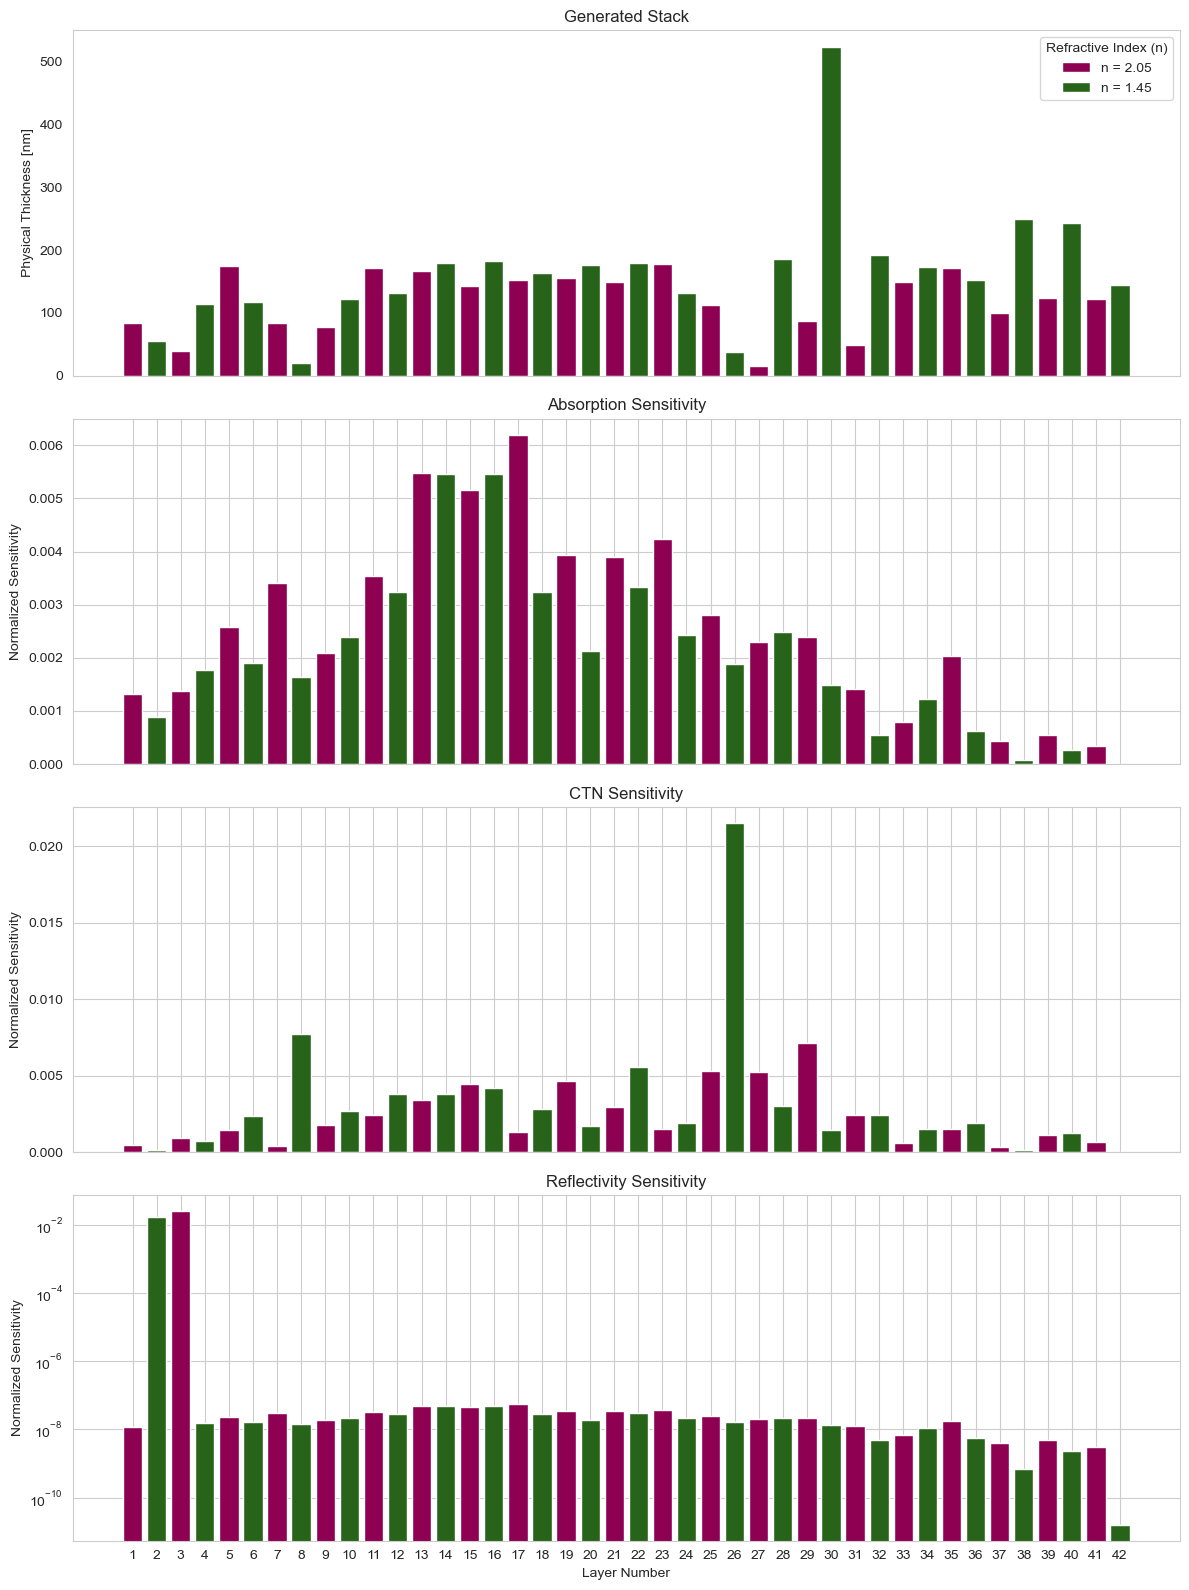

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Ensure necessary variables are defined:
# materialLayer, layer_df_reversed, sensitivity_df

# Number of layers
num_layers = len(materialLayer)
layer_numbers = np.arange(num_layers)

# Get unique refractive indices and assign colors
unique_n = layer_df_reversed['n'].unique()
colors = plt.cm.PiYG(np.linspace(0, 1, len(unique_n)))

# Create a mapping from refractive index to colors
n_to_color = dict(zip(unique_n, colors))

# Create figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)

## --- First Subplot: Generated Stack ---

ax_stack = axes[0]

# Plot the stack as a bar chart
for i in range(num_layers):
    n_value = layer_df_reversed.iloc[i]['n']
    color = n_to_color[n_value]
    thickness = layer_df_reversed.iloc[i]['PhysicalThickness']
    ax_stack.bar(i, thickness, color=color, width=0.8)

ax_stack.set_ylabel('Physical Thickness [nm]')
ax_stack.set_title('Generated Stack')
ax_stack.set_xticks(layer_numbers)
ax_stack.set_xticklabels([])  # Hide x-axis labels on the first subplot
ax_stack.grid(False)

# Simplify the legend to show unique n values
legend_elements = [Patch(facecolor=n_to_color[n], label=f"n = {n}") for n in unique_n]
ax_stack.legend(handles=legend_elements, loc='upper right', title='Refractive Index (n)')

## --- Next Three Subplots: Sensitivities ---

# List of metrics and their corresponding sensitivity data
metrics = [
    ('Absorption Sensitivity', 'Absorption_Sensitivity'),
    ('CTN Sensitivity', 'CTN_Sensitivity'),
    ('Reflectivity Sensitivity', 'Reflectivity_Sensitivity')
]

# Colors for the bars are based on n values
for idx, (title, column) in enumerate(metrics, start=1):
    ax = axes[idx]
    for i in range(num_layers):
        n_value = layer_df_reversed.iloc[i]['n']
        color = n_to_color[n_value]
        sensitivity = sensitivity_df.iloc[i][column]/layer_df_reversed.iloc[i]['PhysicalThickness']
        ax.bar(i, sensitivity, color=color, width=0.8)
    ax.set_ylabel('Normalized Sensitivity')
    ax.set_title(title)
    ax.grid(True)
    if 'ref' in title.lower():
        ax.set_yscale('log')

# Set x-axis labels on the last subplot
axes[-1].set_xlabel('Layer Number')
axes[-1].set_xticks(layer_numbers)
axes[-1].set_xticklabels(layer_numbers + 1)  # Start layer numbering from 1

plt.tight_layout()
plt.show()

In [112]:
'ref' in metrics[2][0].lower()

True

In [91]:
i

42